In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Read image and convert to grayscale

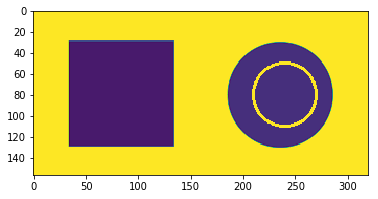

In [2]:
im = cv2.imread("shape.png")
cv2.circle(im, (240,80), 30, (255,255,255), thickness=2)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im)

Detect edges via canny

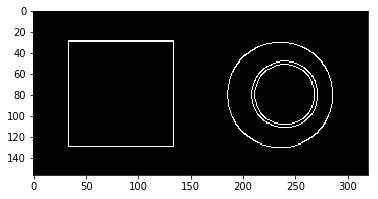

In [3]:
edges = cv2.Canny(im,100,200)
plt.figure()
plt.imshow(edges, cmap="gray")

Define the function to detect lines via hough transform

In [10]:
def hough_lines(edges):
    
    height = edges.shape[0]
    width = edges.shape[1]
    
    # r = x cos (theta) + y sin (theta)
    # initialize thetas
    thetas = np.deg2rad(np.arange(0, 180.0))
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)  
    num_thetas = len(thetas)    
    # initialze r
    max_dist = int(np.ceil(np.sqrt(width * width + height * height)))
    print(max_dist)
    
    # NOT USING AT ALL
    # rhos = np.linspace(-max_dist, max_dist, 2 * max_dist)
        
    # initialize accumulator array
    accumulator = np.zeros(shape=[2 * max_dist, num_thetas])
    
    # iterate through edge map
    for y in range(height):
        for x in range(width):
            
            # if an edge is found
            if(edges[y,x] == 255):
                for theta_id in range(num_thetas):
                    # Calculate rho. max_dist is added for a positive index
                    rho = int(round(x * cos_t[theta_id] + y * sin_t[theta_id]) + max_dist)
                    accumulator[rho, theta_id] += 1
    
    return accumulator, thetas

def hough_circles(edges, r):
    
    height = edges.shape[0]
    width = edges.shape[1]
    
    # initialize thetas
    thetas = np.linspace(0, 2 * np.pi, 200)
        
    # initialize accumulator array
    accumulator = np.zeros(shape=np.shape(edges))
    
    # iterate through edge map
    for y in range(height):
        for x in range(width):
            
            # if an edge is found
            if(edges[y,x] == 255):
                for theta in thetas:
                    x_ = int(x - r * np.cos(theta))
                    y_ = int(y - r * np.sin(theta))                     
                     
                    if(x_ >= 0 and x_ < width and y_ >= 0 and y_ < height):
                        accumulator[y_, x_] += 1
    
    return accumulator

Show accumulator array. Note that theta = thetas[theta_id] and r = r + diag - diag

357


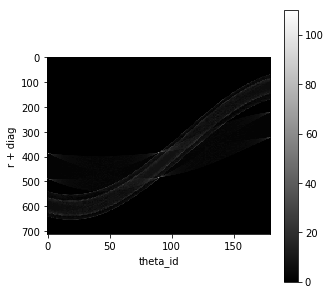

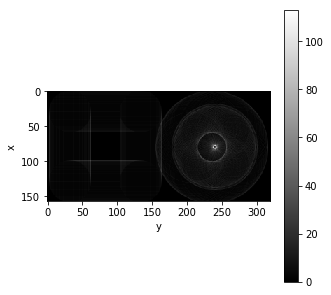

In [11]:
accumulator, thetas = hough_lines(edges)
fig = plt.figure(figsize=(5,5))
plt.imshow(accumulator, cmap="gray", aspect=0.2)
plt.ylabel("r + diag")
plt.xlabel("theta_id")
plt.colorbar()

accumulator_circles = hough_circles(edges, 30)
fig = plt.figure(figsize=(5,5))
plt.imshow(accumulator_circles, cmap="gray", aspect=1)
plt.ylabel("x")
plt.xlabel("y")
plt.colorbar()

Get top K elements and draw their result

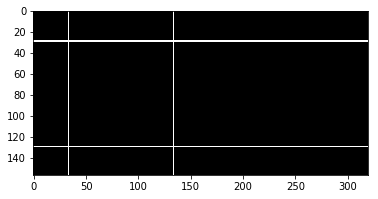

In [12]:
# [0][0] -> rho component, 0'th element
# [1][0] -> theta component, 0'th element
k = 4
top_k = np.argsort(accumulator.flatten())[::-1][:k]
top_k = np.unravel_index(top_k, (np.shape(accumulator)[0], np.shape(accumulator)[1]))

template = np.zeros(shape=np.shape(im))
for i in range(k):
    
    rho = top_k[0][i] - int(np.ceil(np.sqrt(edges.shape[1] * edges.shape[1] + edges.shape[0] * edges.shape[0])))
    theta = thetas[top_k[1][i]]
    
    # vertical line, so just set x0,x1 = rho and y = [0, height]
    if(abs(theta) < 0.01):
        x0 = rho
        x1 = rho
        y0 = 0
        y1 = edges.shape[0]

    # horizontal line, so just set y0,y1 = rho and x = [0, width]
    elif(abs(theta - 1.57) < 0.01):
        x0 = 0
        x1 = edges.shape[1]
        y0 = rho
        y1 = rho

    else:
        x0 = 0
        x1 = edges.shape[1]
        y0 = int((rho - x0*np.cos(theta)) / np.sin(theta))
        y1 = int((rho - x1*np.cos(theta)) / np.sin(theta))

    cv2.line(template,(x0,y0),(x1,y1),(255,0,0),1)
    
plt.figure()
plt.imshow(template, cmap="gray")

In [ ]:
k = 2
top_k = np.argsort(accumulator_circles.flatten())[::-1][:k]
top_k = np.unravel_index(top_k, (np.shape(accumulator_circles)[0], np.shape(accumulator_circles)[1]))

print(top_k)

In [ ]:
k = 2
top_k = np.argsort(accumulator_circles.flatten())[::-1][:k]
top_k = np.unravel_index(top_k, (np.shape(accumulator_circles)[0], np.shape(accumulator_circles)[1]))

template = np.zeros(shape=np.shape(im))
for i in range(k):
    cv2.circle(template,(top_k[1][i],top_k[0][i]),30,(255,255,255),1)
    
plt.figure()
plt.imshow(template, cmap="gray")